In [6]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Maric acid', 'Ash', 'Alcalinity of ash','Magnesium',
                   'Total phenols','Flavanoids','Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                   'Hue','OD280/OD315 of diluted wines', 'Proline']

from sklearn.model_selection import train_test_split
X,y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=0)

# 標準化
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

In [7]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
lr = LogisticRegression(penalty='l1' , C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std,y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

print('intercept', lr.intercept_)
print('coef',lr.coef_)

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481
intercept [-0.38380018 -0.15815202 -0.70043361]
coef [[ 0.2802926   0.          0.         -0.02793707  0.          0.
   0.7101137   0.          0.          0.          0.          0.
   1.23623753]
 [-0.64371473 -0.06892075 -0.05716787  0.          0.          0.          0.
   0.          0.         -0.92724726  0.05968557  0.         -0.37097178]
 [ 0.          0.06151893  0.          0.          0.          0.
  -0.63591525  0.          0.          0.49805586 -0.3582098  -0.57132037
   0.        ]]


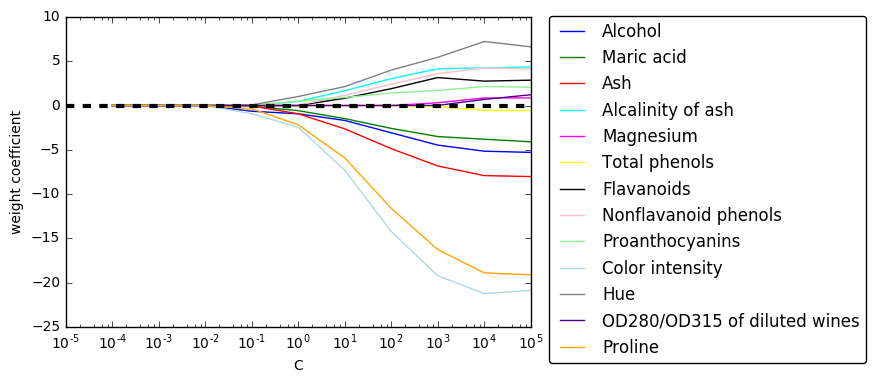

In [19]:
import matplotlib.pyplot as plt

fig= plt.figure()
ax = plt.subplot(111)
colors =['blue','green','red','cyan','magenta','yellow','black','pink','lightgreen','lightblue','gray','indigo','orange']

weights, params = [], []

for c in np.arange(-4,6):
    lr = LogisticRegression(penalty='l1' , C=10**c ,random_state=0)
    lr.fit(X_train_std,y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params,weights[:, column],label=df_wine.columns[column+1],color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
#plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

## SRB

In [5]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X,y):
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=self.test_size,random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train,y_train, X_test, y_test, self.indices_)
        
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets= []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train,y_train, X_test,y_test,p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
            
        self.k_score_= self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self,X_train,y_train, X_test,y_test,indices):
        self.estimator.fit(X_train[:,indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test,y_pred)
        return score

In [8]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Maric acid', 'Ash', 'Alcalinity of ash','Magnesium',
                   'Total phenols','Flavanoids','Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                   'Hue','OD280/OD315 of diluted wines', 'Proline']

from sklearn.model_selection import train_test_split
X,y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=0)

# 標準化
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn,k_features=1)
sbs.fit(X_train_std,y_train)

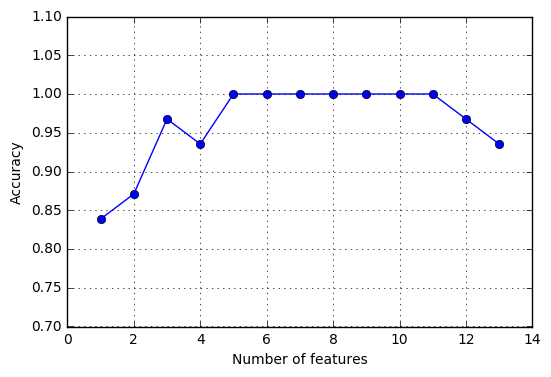

In [10]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_,marker = 'o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [16]:
# 上のグラフでAccuracyが1.00になっている最小の特徴量の数の五つを取り出す。
k5 = list(sbs.subsets_[8])
print(k5)
print(df_wine.columns[1:][k5])

[0, 1, 3, 10, 12]
Index(['Alcohol', 'Maric acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [18]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std,y_train))
print('Test accuracy:', knn.score(X_test_std,y_test))


Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


In [19]:
knn.fit(X_train_std[:,k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:,k5],y_train))
print('Test accuracy:', knn.score(X_test_std[:,k5],y_test))


Training accuracy: 0.959677419355
Test accuracy: 0.925925925926
